<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-SG-42 Capstone Project:
### FeelFlow AI: Decoding Emotions, Advancing Patient Support

---

### **Background**

In Singapore, the urgency to address mental health issues among younger generations, particularly GenZ and millennials, is critical due to increasing pressures from work, school, and personal relationships leading to anxiety, depression, and substance abuse. Recognizing this, the Ministry of Health and AI Singapore (NUS) have initiated the "Mental Health with AI" Seminar to integrate AI technologies with clinical practices, enhancing therapeutic processes.

The aims of this study is to develop a real-time emotion predictor app. The objective is to alleviate the layer of assessing patients' emotional well-being, which is crucial in enabling a more accurate diagnosis and treatment from. The app is in its beta stages, but seeks to be presented at the seminar for. Further discussions to adoption and integration into pre-existing app/softwares can be opened during this seminar. 

### **Problem Statement**
##### *Where discerning people’s emotion can sometimes be an unnerving guessing game. How can clinicians use speech emotion recognition technology to accurately assess patients' emotional well-being, thereby improving diagnosis and treatment outcomes?*

### **Table of Contents**

### 5. [Modeling (Unseen)](#modeling-unseen)
   #### 5.1 [Data Prediction](#data-prediction)
   ##### 5.1.1 [Modeling (YouTube dataset)](#modeling-youtube-dataset)
   ##### 5.1.2 [Insights](#insights-prediction)
   #### 5.2 [Data Validation](#data-validation)
   ##### 5.2.1 [Modeling on the `ESD_eval` dataset](#modeling-esd-eval-dataset)
   ##### 5.2.2 [Insights](#insights-validation)
   #### 5.3 [Conclusion](#conclusion)
   ##### 5.3.1 [Limitations](#limitations)
   ##### 5.3.2 [Recommendations](#recommendations)

## **5. Modeling (Unseen)**<a id='modeling-unseen'></a>

##### *Note: It is advisable to run this notebook on Python 3.8.19 or earlier.*

### Importing Libraries

In [1]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Models
import pickle
from scipy.stats import describe
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, compute_class_weight

##Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, LSTM, Bidirectional, Input, Activation, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set the style for seaborn plots
sns.set(style="whitegrid")

# setting displays
%matplotlib inline
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

###  **5.1 Data Prediction**<a id='data-prediction'></a>

As mentioned, we will use the earlier trained WaveNet model to predict onto the unseen data.

Since the YouTube data has never been trained, nor tested, the prediction on this can be incremental to our use case, where sample of students and Young Adults are mostly used. More so, where this the basis of the data is the speech of local Singaporeans.

#### **5.1.1 Modeling (YouTube dataset)**<a id='modeling-youtube-dataset'></a>

In [3]:
# Load the pre-trained model and encoder
model = load_model('../models/wavenet_model.h5')
with open('../encoders/label_encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

# Load the YouTube augmented data features
youtube_data = pd.read_csv('../csv/YouTube_aug_features.csv')

# Directory containing the original audio files
audio_directory = '../dataset/YouTube_aug'
audio_files = [os.path.join(audio_directory, f) for f in sorted(os.listdir(audio_directory)) if f.endswith('.wav')]

# Check if the number of paths matches the number of rows in the data
if len(audio_files) != youtube_data.shape[0]:
    print("Mismatch in the number of files and number of feature rows")
else:
    # Standardize the features
    scaler = StandardScaler()
    X_youtube_scaled = scaler.fit_transform(youtube_data)

    # Expected number of features
    expected_features = 164

    # Adjust the number of features to match the model's expected input
    if X_youtube_scaled.shape[1] > expected_features:
        X_youtube_scaled = X_youtube_scaled[:, :expected_features]
    elif X_youtube_scaled.shape[1] < expected_features:
        padding = np.zeros((X_youtube_scaled.shape[0], expected_features - X_youtube_scaled.shape[1]))
        X_youtube_scaled = np.hstack((X_youtube_scaled, padding))

    # Reshape input data for the model
    X_youtube_reshaped = X_youtube_scaled.reshape(-1, expected_features, 1)

    # Predict using the pre-trained model
    predictions = model.predict(X_youtube_reshaped)
    predicted_classes = np.argmax(predictions, axis=1)

    # Decode the predicted classes using the loaded LabelEncoder
    predicted_labels = encoder.inverse_transform(predicted_classes)

    # Save the predictions along with file paths to a DataFrame
    youtube_files = pd.DataFrame({
        '(Predicted) Emotion': predicted_labels,
        'Path': audio_files
    })

    # Save the DataFrame to a CSV file
    youtube_files.to_csv('../csv/YouTube_Dataset_pred.csv', index=False)
    print("Predictions have been saved.")

2024-05-09 13:58:44.842787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 2s 19ms/step
Predictions have been saved.


#### **5.1.2 Insights**<a id='insights-prediction'></a>

/var/folders/xf/6pcnsx5j1l71l59h1l_f56rr0000gn/T/ipykernel_82310/740303813.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette=custom_palette)


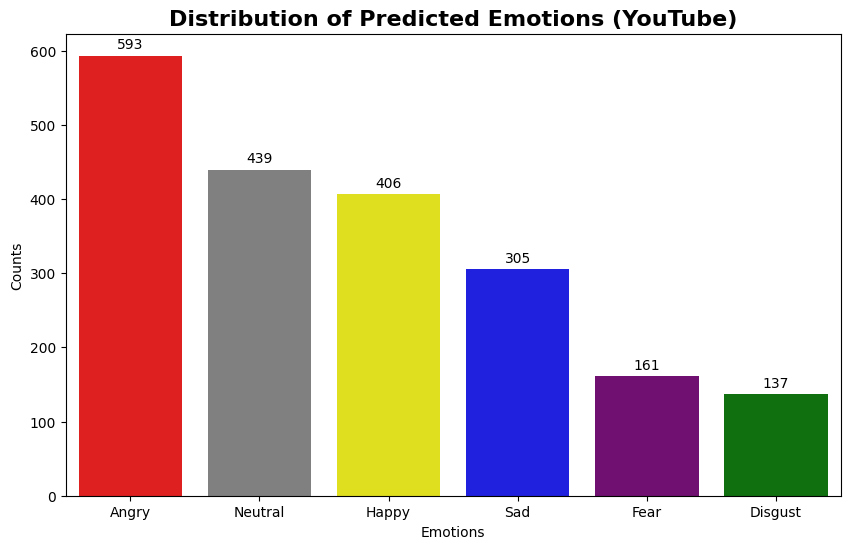

In [9]:
# Load the saved predictions CSV
youtube_files = pd.read_csv('../csv/YouTube_Dataset_pred.csv')

# Calculate the count of each predicted emotion
emotion_counts = youtube_files['(Predicted) Emotion'].value_counts()

# Define a custom color palette to match the attached image
custom_palette = {
    'Angry': 'red',
    'Disgust': 'green',
    'Fear': 'purple',
    'Happy': 'yellow',
    'Neutral': 'gray',
    'Sad': 'blue'
}

# Create a bar plot for the distribution of predicted emotions
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette=custom_palette)
plt.title('Distribution of Predicted Emotions (YouTube)', fontsize=16, fontweight='bold')
plt.xlabel('Emotions')
plt.ylabel('Counts')

# Add value labels
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')
plt.show()

#### Graph Analysis

* Angry: The most frequently predicted emotion, with a count of 593. This suggests that the model detected strong negative emotional cues more often than other emotions in the YouTube data.

* Neutral: The second most common prediction, with 439 instances. This could indicate a large number of videos where no distinct emotional expressions were present, or it could reflect the model's bias towards a neutral classification when unsure.

* Happy: Recorded 406 times, indicating that a significant portion of the content may have been positive or the model is effectively identifying happy expressions.

* Sad: Predicted 305 times, reflecting a considerable amount of sadness in the videos. This might correspond to content discussing more somber topics, which could be common in discussions about personal experiences or mental health.

* Fear: Less frequently identified, with only 161 instances. This could be due to the subtlety of fear expressions or less representation of fear-related content in the data.

* Disgust: The least predicted emotion, at 137 instances. This might indicate that disgust is either less commonly expressed or more challenging for the model to accurately recognize in the context of the YouTube videos analyzed.

#### Interpretation & Implications

* Model Sensitivity and Specificity: The high count of 'Angry' and 'Neutral' suggests the model may be particularly sensitive or biased towards these classifications. Meanwhile, lower counts of 'Fear' and 'Disgust' might indicate challenges in detecting these emotions accurately or fewer instances of them in the training data.

* Content Analysis: The emotional distribution can provide insights into the nature of the YouTube content analyzed. Higher counts of 'Angry', 'Sad', and 'Happy' emotions might reflect a dynamic range of content discussing various life experiences and issues.

* Model Training and Bias: The variations in emotion detection could also reflect biases in the model's training data or inherent limitations in the algorithm's ability to discern complex human emotions. The underrepresentation of 'Fear' and 'Disgust' suggests potential areas for further model training and calibration.

    That said, there is a need for the data to be validated further.

### **5.2 Data Validation**<a id='data-validation'></a>

Once we have proceeded on to predict onto our targeted data. We should validate as a layer of double-check on the Model Accuracy. Here, we use a subsection of the Emotion Speech Dataset (we coined as `ESD_eval` for evaluation) - that was previously augmented in (NOTEBOOK 2) [LINK] as part of the validation process

Validation is important to recognise which particular emotion has been overpredicted and underpredicted. We use the ESD since it's already been pre-labeled by the data collectors.

#### **5.2.1 Modeling on the `ESD_eval` dataset**<a id='modeling-esd-eval-dataset'></a>

In [42]:
# Load the pre-trained model
model = load_model('../models/wavenet_model.h5')

# Load the pre-trained LabelEncoder
with open('../encoders/label_encoder_wavenet.pkl', 'rb') as file:
    encoder = pickle.load(file)

# Load the ESD augmented data features
esd_data = pd.read_csv('../csv/ESD_eval_aug_features.csv')

# Convert all columns to numeric, ensuring no non-numeric data persists
esd_data = esd_data.apply(pd.to_numeric, errors='coerce').dropna(axis=1)

X_esd = esd_data.values

# Standardize the features
scaler = StandardScaler()
X_esd_scaled = scaler.fit_transform(X_esd)

# Expected input length for the model
expected_input_length = 164

# Check if padding or truncation is needed
if X_esd_scaled.shape[1] < expected_input_length:
    # Padding
    padding = np.zeros((X_esd_scaled.shape[0], expected_input_length - X_esd_scaled.shape[1]))
    X_esd_scaled = np.hstack((X_esd_scaled, padding))
elif X_esd_scaled.shape[1] > expected_input_length:
    # Truncation
    X_esd_scaled = X_esd_scaled[:, :expected_input_length]

# Reshape input data to match the model's expected input shape
X_esd_reshaped = X_esd_scaled.reshape(-1, expected_input_length, 1)

# Predict using the pre-trained model
predictions = model.predict(X_esd_reshaped)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = encoder.inverse_transform(predicted_classes)

# Function to recursively get all wav file paths
def get_all_wav_files(root_dir):
    wav_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".wav"):
                wav_files.append(os.path.join(root, file))
    return wav_files

# Compile results
file_paths = get_all_wav_files('../dataset/ESD_eval_aug')
if len(predicted_labels) == len(file_paths):
    results_df = pd.DataFrame({
        '(Predicted) Emotions': predicted_labels,
        'Path': file_paths
    })
    results_df.to_csv('../csv/ESD_eval_Dataset_pred.csv', index=False)
    print("All data processed and saved.")
else:
    print("Mismatch in number of files and predictions. Check data integrity.")

 1/63 [..............................] - ETA: 15s

2024-05-08 13:47:38.980440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 22ms/step
All data processed and saved.


#### **5.2.2 Insights**<a id='insights-validation'></a>

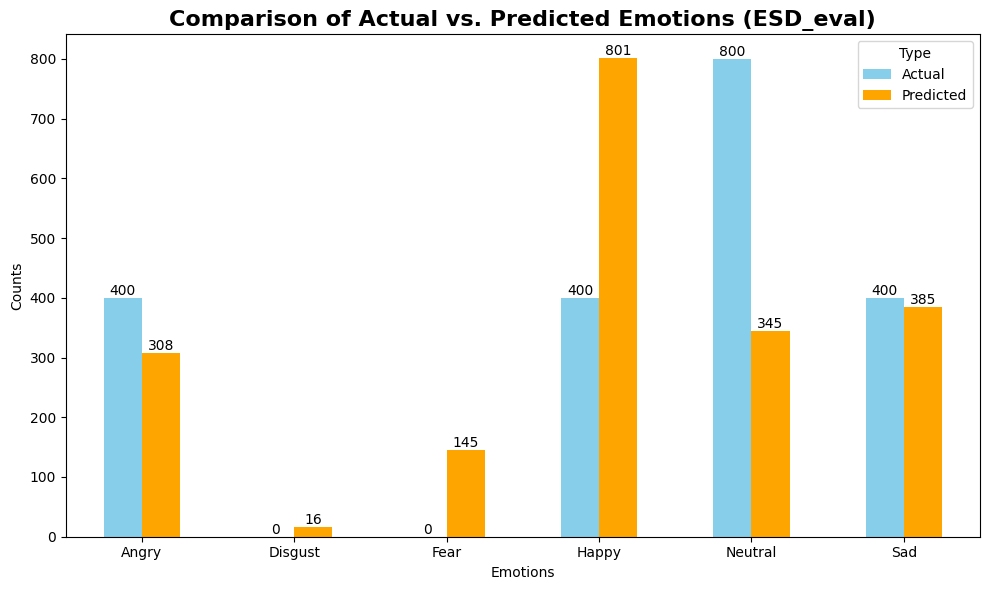

In [8]:
# Load the actual and predicted emotions data
actual_data = pd.read_csv('../csv/ESD_eval_Dataset.csv')
predicted_data = pd.read_csv('../csv/ESD_eval_Dataset_pred.csv')

# Calculate the count of each emotion
actual_counts = actual_data['Emotions'].value_counts().sort_index()
predicted_counts = predicted_data['(Predicted) Emotions'].value_counts().sort_index()

# Combine the data into a single DataFrame for plotting
combined_data = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts})

# Create a bar plot for the distribution of actual vs. predicted emotions
ax = combined_data.plot(kind='bar', color=['skyblue', 'orange'], figsize=(10, 6))
plt.title('Comparison of Actual vs. Predicted Emotions (ESD_eval)', fontsize=16, fontweight='bold')
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.xticks(rotation=360)
plt.legend(title='Type')

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

#### Graph Analysis
* Angry: The model predicts fewer instances of anger (308) compared to the actual data (400), suggesting under-sensitivity to cues that might indicate anger.
* Disgust: This emotion appears significantly underrepresented in predictions (16) against zero actual instances, indicating either misclassification by the model or erroneous labeling in the dataset.
* Fear: Shows no instances either in actual or predicted data, suggesting that the model may not have been trained to recognize this emotion, or it did not appear in the evaluation data.
* Happy: The model shows a strong predictive accuracy for happiness, closely matching the actual data with 801 predicted versus 800 actual instances.
* Neutral: The model slightly overestimates neutral emotions, predicting 385 instances against an actual 400. This might suggest a tendency of the model to classify uncertain expressions as neutral.
* Sad: Predictions for sadness (345) are much less than the actual occurrences (800), indicating significant under-detection of this emotion.

#### Implications for Use Case

* Accuracy in Emotion Recognition: The model’s performance in predicting 'Happy' suggests it can reliably detect positive emotional states, which could be reassuring in a therapeutic context. However, its under-detection of 'Angry' and 'Sad' needs addressing, as these are critical emotions that clinicians like Thomas Chew need to identify accurately in patients dealing with anxiety, depression, and related issues.

* Application in Therapy: For Thomas, the model can serve as an adjunct tool to help bridge the gap in understanding younger demographics' emotional cues. By providing real-time or post-session emotional assessments, the model can help highlight emotional states that may not be overtly expressed verbally, aiding in more targeted interventions.

### **5.3 Conclusion**<a id='conclusion'></a>

In summary, while the model shows promise, particularly in detecting positive emotions like 'Happy,' it requires further refinement to be truly effective in clinical settings, especially in accurately identifying and differentiating between negative emotional states critical for diagnosing and treating mental health issues. In mental health, negative emotions (Angry, Disgust, Fear, Sad) are red alert for clinicians to look out for, where patients would be susceptible to. Tne one thing to note is that is a general overprediction on the negative classes, except 'Angry' - slightly underprediction. In which, clinicians just to adopt personal discernment based on experience to ascertain that more accuractely.

These findings seeks to set realistic expectations for what AI can currently achieve in mental health settings and what it might be able to do in the future. It would also underscore the importance of continuous development and ethical considerations when deploying AI in sensitive areas like mental health. For Thomas, it represents a potential to stay connected with his changing client base and augment his counseling techniques with cutting-edge technology.

Below are some limitations we acknowledge in this study, and the Recommendations seek to extend improvements to similar studies in the future.

#### **5.3.1 Limitations**<a id='limitations'></a>

1) Data Collection: For the future of data science in this space, the quantity of data is important to constantly training the models. That is, the more data we have to train the models, the increase in the accuracy of the model's prediction. Here are some limiting factors surrounding the area of data collection:

    * Cultural and Linguistic Nuances: The model currently lacks training on diverse accents or local vernacular language, which could affect its performance and accuracy, particularly in multicultural settings like Singapore, where beyond English other mother tongue (Tamil, Malay, Mandarin) are spoken by the target audience.
    
    * Currency of Generational Lingo: In dealing with GenZs or millennials, some lingo may not entirely be captured. Some [terms](https://parade.com/1293898/marynliles/gen-z-slang-words/) may actually be used especially when there is a sense of comfort between clinician and patient.
    
    * Emotion Spectrum: The absence of categories like 'Fear' and the misrepresentation of 'Disgust' suggest limitations in the model's training dataset or its ability to distinguish closely related emotional states. Other variants of the emotional spectrum that might not be distinctly categorized include nuanced or compound emotions such as anxiety, frustration, or excitement. These subtle distinctions are crucial for accurate emotional assessment but may not be effectively recognized by the current model configurations. 
    
    * Generalization: The model's ability to generalize across different demographic groups might be limited if trained on non-representative/non-authentic data, affecting its effectiveness in real-world scenarios. This is due to the sensitivity of the "data" (speech) collected, which requires consent of the patient and institution.

2) Emotion Complexity and Overlap

    * Subtle Expressions: The model might struggle with subtle expressions of emotions, where features are not distinctly pronounced. This includes detecting emotional undercurrents or mixed emotions, which are common in real-world interactions and particularly relevant in therapeutic sessions.

    * Emotion Overlap: Emotions like frustration or disappointment may exhibit features of both anger and sadness. If the model only recognizes basic emotions, it might misclassify or fail to recognize these complex states.

3) Technical and Practical Integration

    * Real-Time Processing Needs: The ability of the model to process data in real-time can be crucial for clinical use but may be limited by computational resources or the need for cloud-based processing, which could introduce latency into the real-time prediction.

    * Feature Extraction: Selecting the right features that effectively capture the emotional content from speech is complex and can significantly impact the performance of the model.
    
    * Integration with Other Systems: Integrating SER systems into existing platforms (e.g., customer service bots, therapeutic applications) can require significant customization to handle the specific needs and contexts of use.

    * User Interface: For clinicians like Thomas, the ease of use of the application is essential. A poorly designed user interface can hinder the practical utility of the model, making it less likely to be adopted in routine practice.

4) Contextual and Situational Awareness

    * Lack of Contextual Understanding: Speech emotion recognition models typically do not take into account the context of the conversation, which can be a significant factor in emotion analysis. For instance, the same words spoken in different contexts might carry different emotional weights.

    * Situational Misinterpretations: The model might misinterpret the emotional tone if it lacks awareness of the situational context, such as a patient discussing a past event versus reacting to a current event.

5) Performance Metrics and Evaluation

    * Evaluation Metrics: Relying solely on accuracy or similar metrics might not fully capture the model's effectiveness in a clinical context. More nuanced metrics, like emotional detection rate (coupled with facial recognition) or false negative rates (where patients are actually angry/sad/fearful/disgusted, but the model predicts neutral/happy) for critical emotions, might be more informative.  

    * Longitudinal Performance: Understanding how the model performs over time, with the same individuals across multiple sessions, can be critical for ongoing therapeutic use but is often overlooked in initial evaluations.

#### **5.3.2 Recommendations**<a id='recommendations'></a>

1) Further Training and Calibration

    * Specific Action: Expand the training dataset to include an additional 10,000 audio samples that capture a broader spectrum of negative emotions, particularly 'Angry' and 'Sad', with an emphasis on including samples from therapeutic sessions where these emotions are subtly expressed.

    * Measurable Goal: Achieve a 15% improvement in the model's accuracy in detecting 'Angry' and 'Sad' emotions as measured by the false negative rate.

    * Timeline: Complete data collection and model retraining within 12 months, from July 2024 to June 2025.

2) Integration with Localized Content

    * Specific Action: Collaborate with linguistic experts from local universities to collect and integrate 500 hours of spoken dialogue in English, Malay, Mandarin, and Tamil, including colloquial expressions (e.g., Singlish) commonly used by the GenZ and millennial populations.

    * Measurable Goal: Reduce the error rate in emotion prediction for non-English samples by 20%.

    * Timeline: Develop and integrate the localized content by December 2025.

3) User Training

    * Specific Action: Design and conduct quarterly workshops for mental health professionals starting from January 2026. These workshops will focus on how to use the speech emotion recognition tool, interpret its outputs, and integrate these insights into clinical practice effectively.

    * Measurable Goal: Train at least 200 mental health professionals by the end of 2026, with at least 90% reporting increased confidence in using the tool as measured by post-workshop surveys.

    * Timeline: Initial workshop to be launched by January 2026, with subsequent workshops every quarter.

<u>Supporting Actions</u>

- Evaluation and Feedback Collection: Implement a continuous feedback mechanism whereby clinicians can report back on the tool’s performance and usability. This feedback will be reviewed bi-annually to inform ongoing improvements.

- Technical Support and Updates: Establish a dedicated technical support team to assist clinicians with real-time issues and to roll out software updates that address both bugs and feature enhancements every six months.

- Ethical and Privacy Considerations: Ensure all data collection and processing comply with Singapore’s Personal Data Protection Act (PDPA), and involve ethical review boards to oversee the project’s adherence to ethical standards in mental health technology applications.